# Data loading

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA


In [2]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [3]:

X_train, y_train = load_mnist('data/fashion', kind='train')
X_test, y_test = load_mnist('data/fashion', kind='t10k')

In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

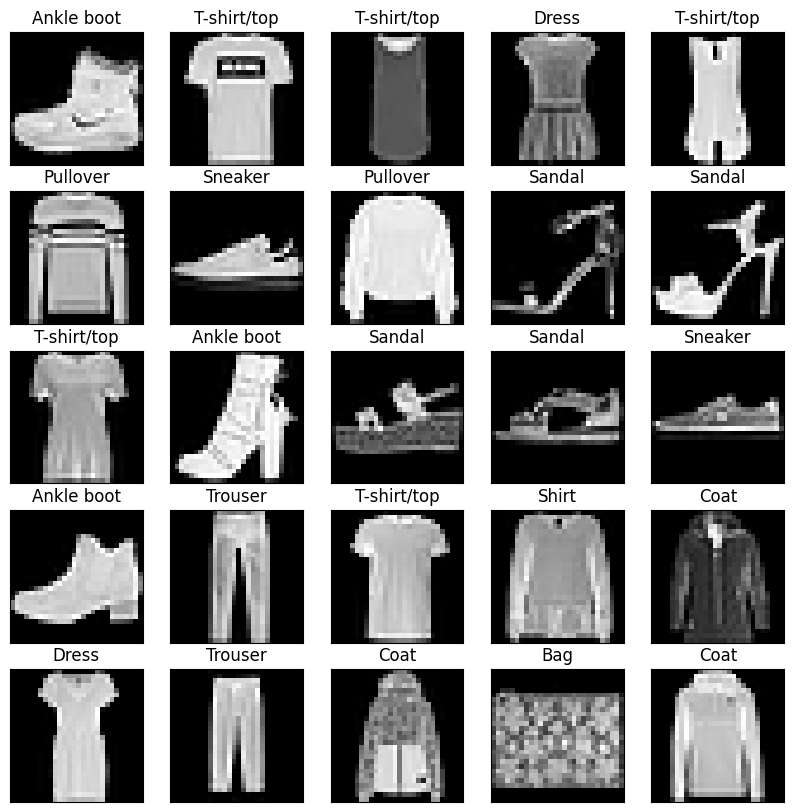

In [5]:
# Classes of Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot some sample images (need to reshape each sample back to 28x28 for visualization)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')  # Reshape for plotting
    plt.title(class_names[y_train[i]])
plt.show()

# Preprocessing data

In [7]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [8]:
Xmean = X_train.mean(axis=0)
X_train_normalized = X_train - Xmean
X_test_normalized = X_test - Xmean

# Training and Evaluation

In [11]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train_normalized, y_train)

LinearSVC(random_state=42)

In [12]:
y_pred_train = lin_clf.predict(X_train_normalized)
accuracy_score(y_train, y_pred_train)

0.87365

In [13]:
y_pred_test = lin_clf.predict(X_test_normalized)
accuracy_score(y_test, y_pred_test)

0.8401

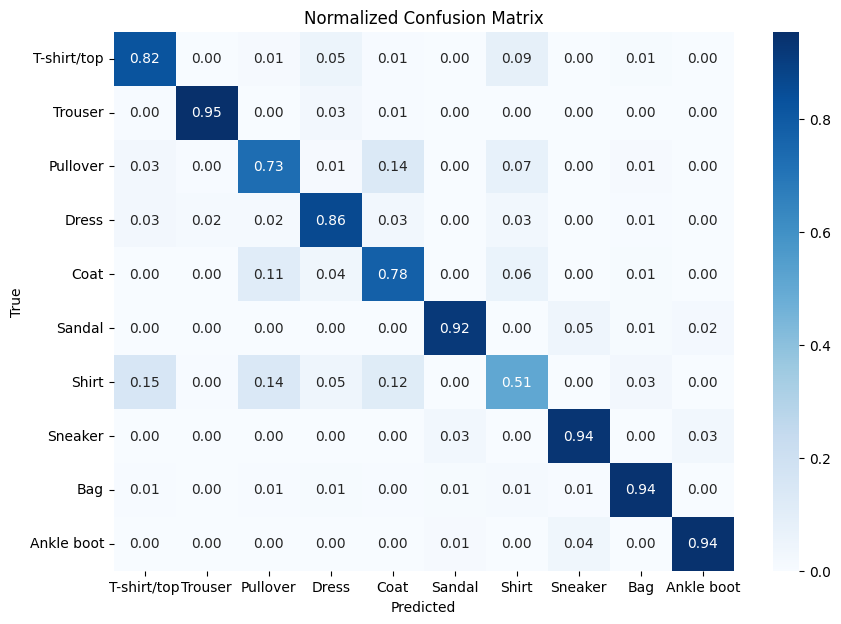

In [14]:
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Normalize Confusion Matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

Khi train trên SVM linear thì tốn khá nhiều thời gian để train nên ta sẽ quyết định train 10k ảnh để rút ngắn thời gian training, nhưng vẫn cần đảm bảo dữ liệu có nhãn balance khi lấy sample, hướng tiếp cận này là **two-stage training**

In [9]:
num_class = 10
sample_per_class = 1000

X_balance = []
y_balance = []

for i in range(num_class):
    class_indices = np.where(y_train == i)[0]
    chosen_indices = np.random.choice(class_indices, sample_per_class, replace=False)

    X_balance.append(X_train_normalized[chosen_indices])
    y_balance.append(y_train[chosen_indices])

X_small = np.vstack(X_balance)
y_small = np.hstack(y_balance)

In [10]:
svm_clf = SVC(gamma="scale")
svm_clf.fit(X_small, y_small)

SVC()

In [11]:
y_pred = svm_clf.predict(X_small)
accuracy_score(y_small, y_pred)

0.9181

Sau khi train thử với bộ dữ liệu nhỏ hơn 6 lần bộ dữ liệu ban đầu thì kết quả cho ra cũng đã cao hơn 0.87365 của SVM linear khi được train trên tập dữ liệu gốc

In [60]:

# kfold = KFold(n_splits=3, shuffle=True, random_state=42)
# param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
# rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=kfold)

# rnd_search_cv.fit(X_small, y_small)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ....C=9.864114650076273, gamma=0.014514082980152773; total time=  16.7s
[CV] END ....C=9.864114650076273, gamma=0.014514082980152773; total time=  17.3s
[CV] END ....C=9.864114650076273, gamma=0.014514082980152773; total time=  17.9s
[CV] END ...C=2.112773152668849, gamma=0.0015308281532307826; total time=  15.7s
[CV] END ...C=2.112773152668849, gamma=0.0015308281532307826; total time=  15.0s
[CV] END ...C=2.112773152668849, gamma=0.0015308281532307826; total time=  14.8s
[CV] END ...C=3.6569508001557063, gamma=0.054318743185444295; total time=  28.6s
[CV] END ...C=3.6569508001557063, gamma=0.054318743185444295; total time=  29.0s
[CV] END ...C=3.6569508001557063, gamma=0.054318743185444295; total time=  29.1s
[CV] END ......C=4.986774048223781, gamma=0.0444406029165897; total time=  25.8s
[CV] END ......C=4.986774048223781, gamma=0.0444406029165897; total time=  26.6s
[CV] END ......C=4.986774048223781, gamma=0.0444

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=SVC(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001BEA1CFF7C0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001BE9A72D810>},
                   verbose=2)

In [19]:

X_small_df = pd.DataFrame(X_small)
y_small_df = pd.DataFrame(y_small)

Cs = np.logspace(-2, 3, num=10)
MCV_list = []

for C in Cs:
    current_svm = SVC(kernel='rbf', C=C)
    kf = KFold(n_splits=3, random_state=1, shuffle=True)
        
    mean_crossval = np.mean(cross_val_score(current_svm, X_small_df, y_small_df, cv=kf))
    MCV_list.append(mean_crossval)
    print("On C=", C, "\tMCV=", mean_crossval)
    


c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


On C= 0.01 	MCV= 0.7011010939126306


c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


On C= 0.03593813663804628 	MCV= 0.7537006550085122


c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


On C= 0.1291549665014884 	MCV= 0.8049000760903925


c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


On C= 0.464158883361278 	MCV= 0.8428002068353205


c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


On C= 1.6681005372000592 	MCV= 0.8678998073772585


c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


On C= 5.994842503189409 	MCV= 0.8732000674572556


c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


On C= 21.544346900318846 	MCV= 0.8705004573642726


c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


On C= 77.42636826811278 	MCV= 0.8706005273592746


c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


On C= 278.2559402207126 	MCV= 0.8706005273592746


c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Daniel\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


On C= 1000.0 	MCV= 0.8706005273592746


<Figure size 1500x1000 with 0 Axes>

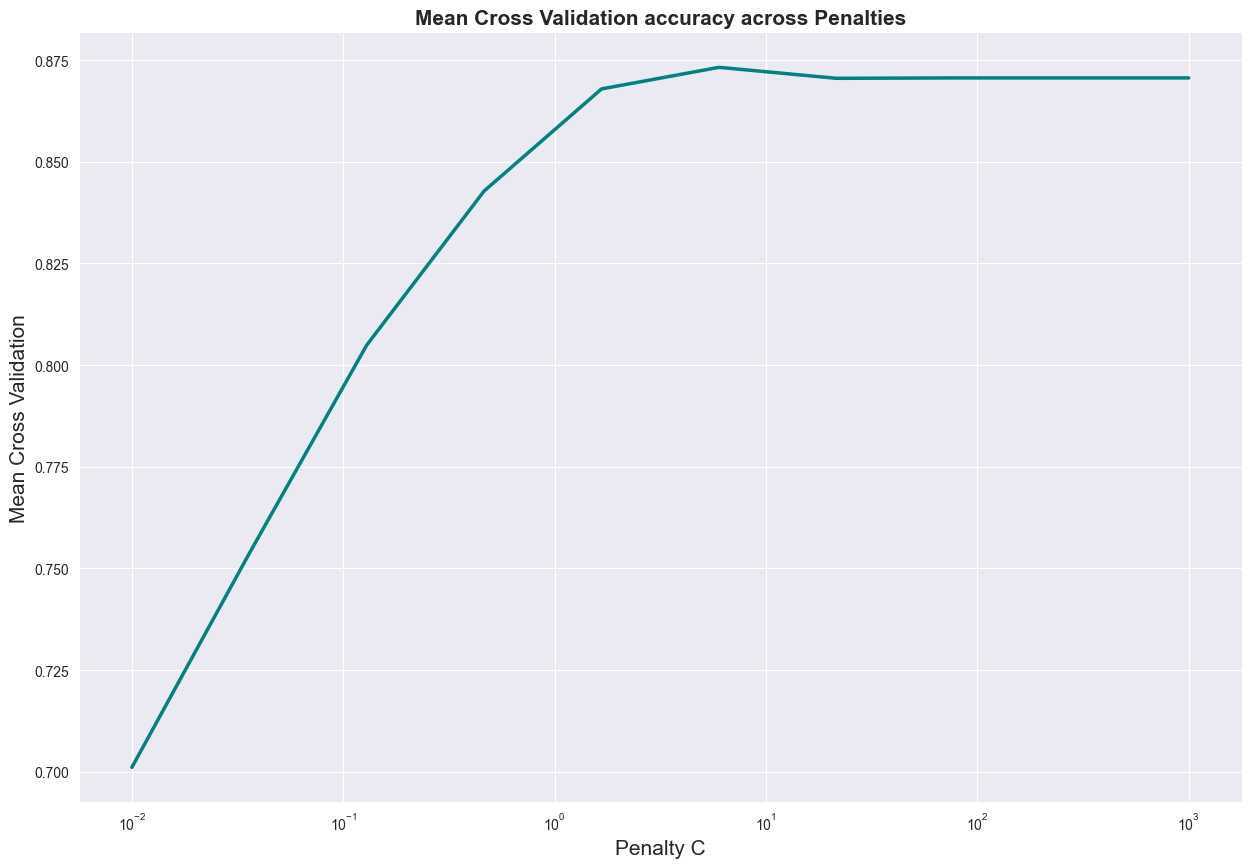

In [20]:
# Set plot specifications
sns.set_style('darkgrid')
fig = plt.figure(figsize=(15,10))
lw = 2.5

plt.plot(Cs, MCV_list, color= 'teal', linewidth = lw)
plt.title("Mean Cross Validation accuracy across Penalties" ,fontsize=15, fontweight="bold")
plt.xlabel('Penalty C', fontsize = 15)
plt.xscale("log")
plt.ylabel('Mean Cross Validation', fontsize = 15)
plt.show()

Sau đó ta tiến hành train trên toàn bộ tập dữ liệu sau khi tìm ra được tham số C tối ưu cho tập dữ liệu nhỏ

In [22]:
optimal_C= 1.6681005372000592
final_svm = SVC(kernel='rbf', C=optimal_C)
final_svm.fit(X_train_normalized, y_train)

y_pred = final_svm.predict(X_test_normalized)
train_accuracy = final_svm.score(X_train_normalized, y_train)
test_accuracy = final_svm.score(X_test_normalized, y_test)

print("Train Accuracy: ", train_accuracy)
print("Test Accuracy: ", test_accuracy)

Train Accuracy:  0.9387833333333333
Test Accuracy:  0.8925


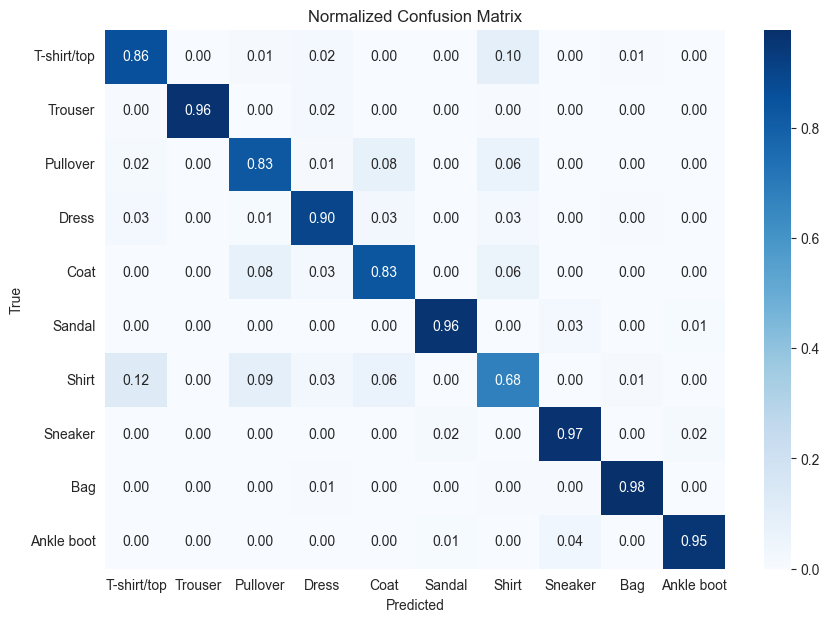

In [23]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Normalize Confusion Matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

# Dimension reduce by using PCA and Evaluate of reduce models

Text(0.5, 1.0, 'Decision surface of Support Vector Machine')

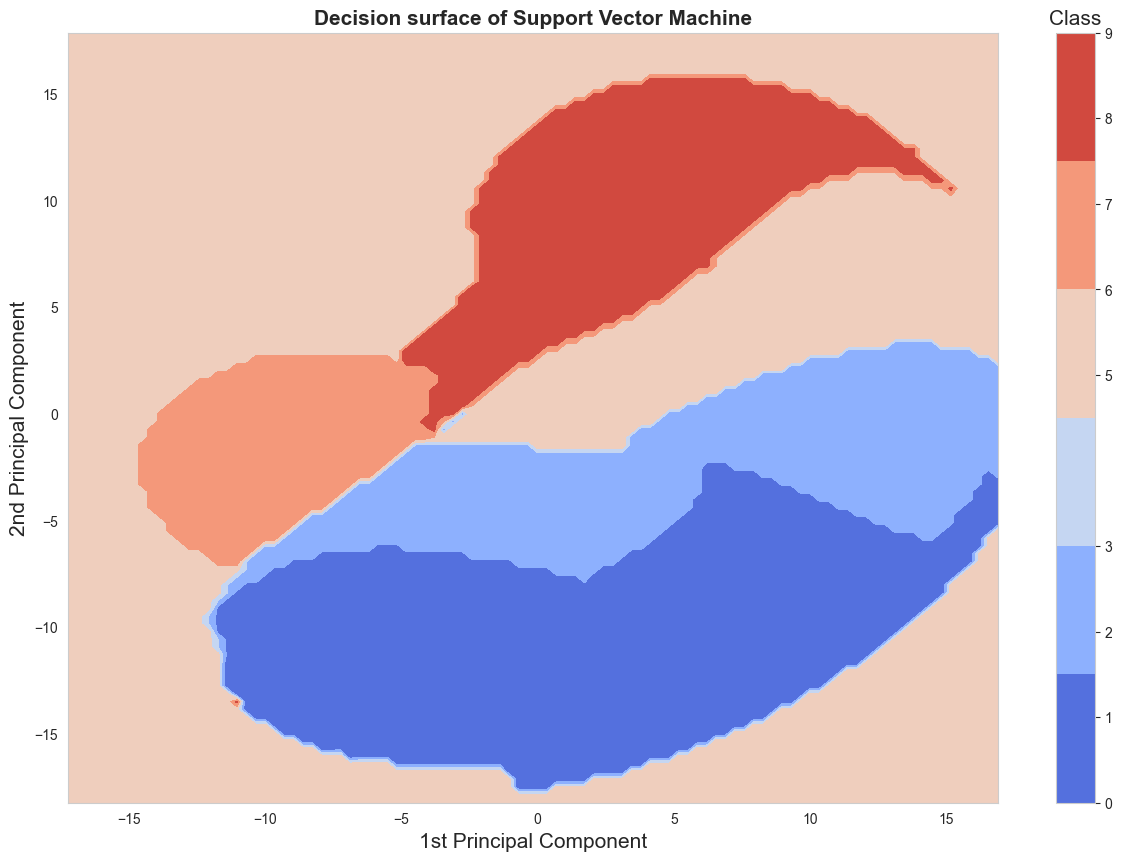

In [25]:
pca = PCA(n_components=2)

Z = pca.fit_transform(X_train_normalized)

V = pca.components_

Z_x = Z[0]
Z_y = Z[1]

std_x = np.std(Z_x)
std_y = np.std(Z_y)

x_min, x_max = -5*std_x, 5*std_x
y_min, y_max = -5*std_y, 5*std_y
x_step = std_x/10
y_step = std_y/10

xx, yy = np.meshgrid(np.arange(x_min, x_max, x_step), np.arange(y_min, y_max, y_step))

z = np.c_[xx.ravel(), yy.ravel()]

x = np.dot(z,V)

predictions = final_svm.predict(x)
predictions = predictions.reshape(xx.shape)

# Plot decision boundaries
sns.set_style("whitegrid")
plt.figure(figsize = (15,10))
contour = plt.contourf(xx, yy, predictions, cmap=plt.cm.coolwarm)
clb = plt.colorbar(contour, boundaries=list(np.unique(predictions)),
                        ticks=list(np.unique(predictions)),spacing='proportional')
clb.ax.set_title('Class', fontsize=15)
plt.xlabel('1st Principal Component', fontsize = 15)
plt.ylabel('2nd Principal Component', fontsize = 15)
plt.title("Decision surface of Support Vector Machine", fontweight = 'bold', fontsize=15)